# 20191117-光大证券-技术指标系列报告之六：RSRS择时_回顾与改进

RSRS在2017-2019的测试集中效果小结：<br>
1.在趋势行情下误判少，能及时入场退场；2.在震荡行情中，信号胜率有所下滑 3.在2019后半年开始，择时效果不佳

## 改进1. 加权线性回归 （效果不佳）

考虑根据距离当前时刻的远近来给不同日期的样本点加权，逻辑在于离当前越近的数据其信息衰减与信息滞后越小。例如线性加权回归，赋予距离当前交易日i日前的样本点的权重为$\frac{N-i}{(N+1)N/2}$，构成等差数列且加和为1。再如指数加权回归$(\frac{2}{N+1} \cdot \left(\frac{N-1}{N+1}\right)^i)$，采用指数增长的模式，且由拉格朗日展开式可知加和近似为1。然而回测后发现效果不佳。

再尝试用每日成交额来赋权，在不同指数上表现有好有差。

## 改进2. 融入市场波动调整指标敏感度（较为有效）

对于之前提出的修正标准分 $$
RSRS = z\_score(beta)* R^2
$$
当回归模型解释力度较弱时，乘以$R^2$可以让标准分的绝对值更小。由于策略激活的条件是大于阈值的标准分，因此此时的标准分是被钝化了。
考虑到RSRS在震荡市中表现不佳，可以尝试在市场震荡的时候钝化指标值，从而减少错误的开仓。对RSRS指标做出如下调整：$$
\text{钝化RSRS指标} = z\_score(beta)*R^\text{4*quantile(std(return),M)}
$$
quantile(std(return),M)表示当前市场收益率波动率在过去M日的历史波动率中所处的分位数的大小。震荡水平越高，分位数越大，RSRS指标将得到更大的钝化效果。

In [87]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import tushare as ts
import akshare as ak
import os
data = ak.stock_zh_index_daily(symbol = "sh000016")
df = data.copy()

#计算必要的指标

def cal_RSRS(df, N):        #计算RSRS斜率
    global k_list
    global R2_list
    k_list = [np.nan] * N 
    R2_list = [np.nan] * N
    for row in  range(len(df) - N):
        y = df['high'][row:row + N]
        x = df['low'][row:row + N]
        k, res = np.polyfit(x, y ,1)
        predicted_y = k * x + res
        residuals = y - predicted_y
        ssr = np.sum(residuals**2)  
        sst = np.sum((y - np.mean(y))**2)
        R2 = 1 - (ssr / sst)   #计算回归的R2值，用于修正标准分的计算
        R2_list.append(R2)
        k_list.append(k)
    df['R2'] = R2_list
    df['k'] = k_list
    df['RSRS'] = k_list
    return df

RSRS_df = cal_RSRS(df, 18)

def cal_z_score_and_volatility(df, N, M):   #计算RSRS标准分与收益率波动率, M为时间窗口
    df['RSRS_1'] = df['RSRS'].fillna(0)
    score = (df['RSRS_1']-df['RSRS_1'].rolling(M).mean())/df['RSRS_1'].rolling(M).std()
    df['RSRS_score'] = score.fillna(0)

    df['ret'] = df['close'] / df['close'].shift(1) - 1
    ret_std = df['ret'].rolling(N,min_periods=1).apply(np.nanstd,raw=False) #这两行复制的Hugo2046的代码
    ret_quantile = ret_std.rolling(M).apply(
        lambda x: x.rank(pct=True).iloc[-1], raw=False)
    df['vol'] = ret_quantile.fillna(0)
    
    df = df.drop(columns = 'RSRS_1')
    df = df.drop(columns = 'ret')
    return df

RSRS_Z = cal_z_score_and_volatility(RSRS_df, 18, 600)
print(RSRS_Z)    

            date      open      high       low     close      volume  \
0     2004-01-02   996.996  1021.568   993.892  1011.347     8064653   
1     2004-01-05  1008.279  1060.898  1008.279  1060.801  1446818000   
2     2004-01-06  1059.141  1086.694  1059.095  1075.656  1699133400   
3     2004-01-07  1075.562  1095.841  1070.980  1086.303  1372941900   
4     2004-01-08  1087.680  1108.291  1082.509  1102.662  1078042700   
...          ...       ...       ...       ...       ...         ...   
4815  2023-10-31  2409.895  2416.574  2400.261  2411.479  3139368100   
4816  2023-11-01  2456.381  2456.381  2416.677  2420.735  2595050600   
4817  2023-11-02  2429.719  2440.336  2416.663  2417.459  2531333000   
4818  2023-11-03  2419.687  2443.301  2418.919  2436.941  2443024900   
4819  2023-11-06  2452.840  2460.763  2443.391  2456.775  3944849300   

            R2         k      RSRS  RSRS_score       vol  
0          NaN       NaN       NaN    0.000000  0.000000  
1          NaN   

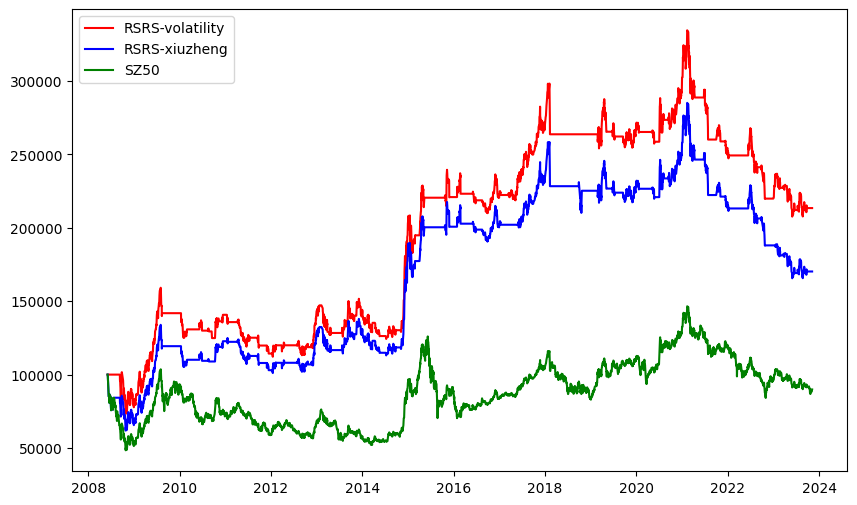

In [89]:
#开始执行策略
portfolio_xiuzheng = pd.DataFrame({'value':[0] * (RSRS_Z.shape[0])})
portfolio_volatility = pd.DataFrame({'value':[0] * (RSRS_Z.shape[0])})

def RSRS_volatility(): #钝化标准分
    cash = 100000
    stocks = 0
    for k in range(1070, len(RSRS_Z)):
        if RSRS_Z['RSRS_score'][k] * (df['R2'][k]) ** (2 * df['vol'][k]) > 0.7:
            if cash > 0:
                stocks += cash // RSRS_Z['close'][k]
                cash = cash % RSRS_Z['close'][k]
        elif RSRS_Z['RSRS_score'][k] * df['R2'][k]< -0.7:
            if stocks > 0:
                cash += stocks * RSRS_Z['close'][k]
                stocks = 0
        portfolio_volatility['value'][k] = cash + stocks * RSRS_Z['close'][k]  

def RSRS_xiuzheng(): #修正标准分作为参照
    cash = 100000
    stocks = 0
    for k in range(1070, len(RSRS_Z)):
        if RSRS_Z['RSRS_score'][k] * df['R2'][k] > 0.7:
            if cash > 0:
                stocks += cash // RSRS_Z['close'][k]
                cash = cash % RSRS_Z['close'][k]
        elif RSRS_Z['RSRS_score'][k] * df['R2'][k]< -0.7:
            if stocks > 0:
                cash += stocks * RSRS_Z['close'][k]
                stocks = 0
        portfolio_xiuzheng['value'][k] = cash + stocks * RSRS_Z['close'][k]

RSRS_volatility()
RSRS_xiuzheng()

n = 100000 // data['close'][1070]
r = 100000 % data['close'][1070]
plt.figure(figsize=(10, 6))
plt.plot(df['date'][1070:], portfolio_volatility['value'][1070:], color='red', label='RSRS-volatility')
plt.plot(df['date'][1070:], portfolio_xiuzheng['value'][1070:], color='blue', label='RSRS-xiuzheng')
plt.plot(df['date'][1070:], df['close'][1070:] * n + r, color='green', label='SZ50')
plt.legend()

钝化RSRS指标在不同指数上效果不一。<br>
研报的结果：沪深 300 上的择时
效果稍有提升，年化收益率微增，最大回撤微降，而胜率有较大改善。同
其它宽基指数上钝化 RSRS 指标的表现均强于原始 RSRS 指标的择时效，
在交易波动更易变化的中证 500 与创业板指上择时效果显著提升，而大盘
股指上的择时效果提升幅度较

我这里和研报回测的结果不一样，中证500并没有很大的提升，而上证50提升较高。只里就先放上了上证50的提高）

**改进3.** 成交额加权线性回归+钝化（无成交额数据），未回测。结果是该方法在中证500上效果优秀，在其他指数上未有明显改进。